# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

In [2]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('Churn.csv')    

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Исходя из имеющейся у нас документации:

*Признаки*
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

*Целевой признак*
* Exited — факт ухода клиента

In [4]:
data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1, inplace=True) # удаляем столбец с фамилией клиента так как 
                                            # нам достаточно и уникального идентификатора клиента

In [5]:
gender_one_hot = pd.get_dummies(data['Gender'], drop_first=True)
country_one_hot = pd.get_dummies(data['Geography'], drop_first=True)
data.drop(['Gender', 'Geography'], axis=1, inplace=True)
df = pd.concat([data, gender_one_hot, country_one_hot], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Tenure           9091 non-null   float64
 3   Balance          10000 non-null  float64
 4   NumOfProducts    10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Exited           10000 non-null  int64  
 9   Male             10000 non-null  uint8  
 10  Germany          10000 non-null  uint8  
 11  Spain            10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Germany,Spain
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.545700,0.250900,0.247700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.497932,0.433553,0.431698
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.isna().sum()

CreditScore          0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Male                 0
Germany              0
Spain                0
dtype: int64

Пропуски в данных о том сколько лет клиент пользуется услугами нашего банка. Скорее всего это новые клиенты, и с нами они менее года. Заменим пропущеные значения на -1.

In [9]:
df['Tenure'] = df['Tenure'].fillna(-1)

In [10]:
df['Tenure'].isna().sum()

0

In [11]:
df.duplicated().sum()

0

In [12]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Число клиентов покинувших наш банк почти в 4 раза меньше, чем клиентов пока ещё остающихся с нами.

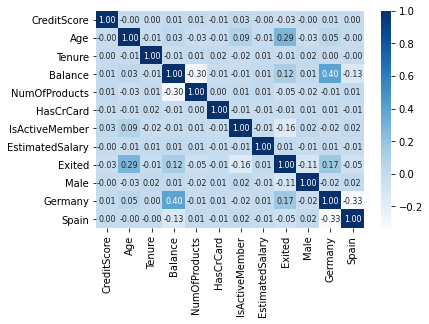

In [13]:
sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':8});

Мультиколлинеарных признаков не наблюдается.

### Разобьем данные на выборки

In [14]:
df_ohe = pd.get_dummies(df, drop_first=True)

target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=12345)
print(features_train.shape, features_valid.shape, features_test.shape)
print(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


In [15]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_train.head()

/tmp/ipykernel_111/3945192486.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male,Germany,Spain
7479,-0.886751,-0.373192,1.083651,1.232271,1,1,0,-0.187705,1,0,1
3411,0.608663,-0.183385,1.083651,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.452862,1.027098,2,0,1,1.503095,1,1,0
1247,-1.457915,-1.417129,0.469046,-1.233163,2,1,0,-1.071061,1,0,0
3716,0.130961,-1.132419,-0.760164,1.140475,1,0,0,1.524268,0,1,0


## Исследование задачи

### Баланс классов

In [16]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Наблюдается дисбаланс в сторону *0* значений.

### Обучим модели без учета дисбаланса

#### Случайный лес

In [17]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 22, 2):
    for n_est in range(100, 1001, 100):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(predictions, target_valid)
        score = f1_score(predictions, target_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
    
print(f'Accuracy: {best_result}. EST:{n_est}. Глубина дерева: {best_depth}. F1: {score}')

Accuracy: 0.864. EST:1000. Глубина дерева: 13. F1: 0.5782414307004471


#### Логистическая регрессия

In [18]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(predictions, target_valid)
score = f1_score(predictions, target_valid)
print(f'Accuracy: {result}. F1: {score}')

Accuracy: 0.802. F1: 0.33108108108108103


AUC-ROC: 0.758536526352083


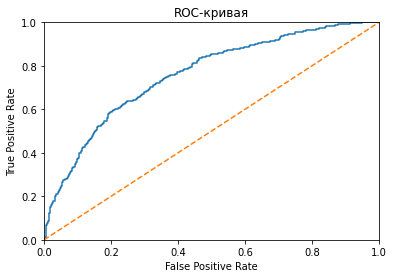

In [19]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC: {auc_roc}')

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

На несбалансированных данных логистическая регрессия показывает слишком низкий параметр F1. F1  мера у случайного леса хоть и выше чем у логистической регрессии, 0.5782, все же не достаточно для дальнейшей работы.
Площадь под ROC кривой (метрика AUC-ROC) ровна 0.7585.

## Борьба с дисбалансом

### Upsampling

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat=4)

In [21]:
model_ups = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=1000)
model_ups.fit(features_upsampled, target_upsampled)
predictions = model_ups.predict(features_valid)
result = accuracy_score(predictions, target_valid)
score = f1_score(predictions, target_valid)
print(f'Accuracy: {result}. F1: {score}')

Accuracy: 0.844. F1: 0.6204379562043797


### Downsampling

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, fraction=0.5)

In [23]:
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=1000)
model.fit(features_downsampled, target_downsampled)
predictions = model.predict(features_valid)
result = accuracy_score(predictions, target_valid)
score = f1_score(predictions, target_valid)
print(f'Accuracy: {result}. F1: {score}')

Accuracy: 0.8455. F1: 0.6180469715698393


## Тестирование модели

In [24]:
model_ups.fit(features_train, target_train)
predictions = model_ups.predict(features_test)
result = accuracy_score(predictions, target_test)
score = f1_score(predictions, target_test)
print(f'Accuracy: {result}. F1: {score}')

Accuracy: 0.675. F1: 0.4482173174872666


AUC-ROC: 0.6826687114265197


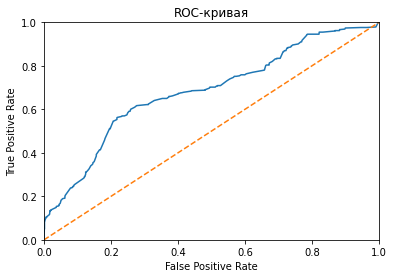

In [25]:
probabilities_test = model_ups.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'AUC-ROC: {auc_roc}')

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

AUC-ROC: 0.6826, точность предсказаний стала ниже. 

# Выводы

* Первичный анализ данных показал явный дисбаланс классов, примерно 4 к 1;
* Произвели предобработку данных;
* Заполнили пропуски;
* Провели one_hot_encoding; 
* Модель случайного леса, до борьбы с дисбалансом, показывала результат F1 метрики 0.5782;
* Upsampling дал результат F1 меры равный 0.6204;
* Dowmsampling оказался менее эффективен, и показал 0.6180;
* Проверка на тестовой выборке проверка на тестовой выборке показала результат 0.4482.
* Площадь под ROC-кривой уменьшилась на 7%.